In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
import torch.nn as nn
import sys
import os
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import HTML, display

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [3]:
class AWA2(Dataset):
    def __init__(
        self,
        classes_file,
        transform=None,
        path_prefix="data",
        predicate_binary_mask=True,
    ):
        self.transform = transform

        if predicate_binary_mask:
            self.predicates_mat = np.genfromtxt(
                os.path.join(path_prefix, "predicate-matrix-binary.txt"), dtype="float"
            )
        else:
            self.predicates_mat = np.genfromtxt(
                os.path.join(path_prefix, "predicate-matrix-continuous.txt"),
                dtype="float",
            )

        self.classes_dict = {}
        classes_array = np.genfromtxt(
            os.path.join(path_prefix, "classes.txt"), dtype="str"
        )
        for row in classes_array:
            self.classes_dict[row[1]] = int(row[0]) - 1
        image_names = []
        image_class_index = []

        self.classes = []
        with open(os.path.join(path_prefix, classes_file)) as f:
            for line in f:
                class_name = line.strip()
                self.classes.append(class_name)
                images = glob(
                    os.path.join(path_prefix, "JPEGImages", class_name, "*.jpg")
                )

                class_index = self.classes_dict[class_name]
                for image in images:
                    image_names.append(image)
                    image_class_index.append(class_index)

        self.image_names = image_names
        self.image_class_index = image_class_index
        self.len = len(self.image_names)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        image = Image.open(self.image_names[index])
        #         print(image.shape)
        if image.getbands()[0] == "L":
            image = image.convert("RGB")
        #         if image.shape != (3,224,224):
        #             print(self.image_class_index[index])
        if self.transform:
            image = self.transform(image)
        class_index = self.image_class_index[index]
        image_predicate = self.predicates_mat[class_index, :]
        return image, class_index, self.image_names[index], image_predicate

    def display_sample(self, n=1):
        for i in range(n):
            plt.imshow(self.__getitem__(i)[0])

In [4]:
train_transformers = transforms.Compose(
    [
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.Resize((224, 224)),  # ImageNet standard
        transforms.ToTensor(),
    ]
)

test_transformers = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor()]
)

In [5]:
test_dataset = AWA2(
    classes_file="testclasses.txt", path_prefix="data1", transform=train_transformers
)
train_dataset = AWA2(
    classes_file="trainclasses.txt", path_prefix="data1", transform=test_transformers
)
len(train_dataset.classes), len(test_dataset.classes)

(40, 10)

In [6]:
train_params = {"batch_size": 24, "shuffle": True, "num_workers": 0}
test_params = {"batch_size": 1, "shuffle": True, "num_workers": 0}
train_loader = DataLoader(train_dataset, **train_params)
test_loader = DataLoader(test_dataset, **test_params)

In [7]:
def predicates_ground_truth(
    path_prefix="data", predicate_binary_mask=True, train_classes="trainclasses.txt"
):
    predicates_mat = None
    if predicate_binary_mask:
        predicates_mat = np.genfromtxt(
            os.path.join(path_prefix, "predicate-matrix-binary.txt"), dtype="float"
        )
    else:
        predicates_mat = np.genfromtxt(
            os.path.join(path_prefix, "predicate-matrix-continuous.txt"), dtype="float",
        )
    classes_array = np.genfromtxt(
        os.path.join(path_prefix, "classes.txt"), dtype="str"
    )[:, -1]
    train_classes = np.genfromtxt(os.path.join(path_prefix, train_classes), dtype="str")
    return predicates_mat, len(predicates_mat), classes_array, train_classes


predicates, num_predicates, classes, train_classes = predicates_ground_truth(
    path_prefix="data1"
)
predicates.shape, num_predicates, len(classes), len(train_classes)

((50, 85), 50, 50, 40)

In [8]:
def build_model(is_pretrained=True, resnet="resnet34", num_predicates=85):
    model = None
    if resnet == "resnet18":
        model = torchvision.models.resnet18(pretrained=is_pretrained)
    elif resnet == "resnet50":
        model = torchvision.models.resnet50(pretrained=is_pretrained)
    else:
        model = torchvision.models.resnet34(pretrained=is_pretrained)
    if is_pretrained:
        for param in model.parameters():
            param.requires_grad = False
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.BatchNorm1d(num_features),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(num_features, num_predicates),
    )
    return model

In [9]:
model = build_model().to(device)
model.fc, next(model.parameters()).is_cuda

(Sequential(
   (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (1): ReLU()
   (2): Dropout(p=0.25, inplace=False)
   (3): Linear(in_features=512, out_features=85, bias=True)
 ),
 True)

In [10]:
# COPIED CONTENT
def cos_loss(input, target):
    return 1 - F.cosine_similarity(input, target).mean()


class AverageBase(object):
    def __init__(self, value=0):
        self.value = float(value) if value is not None else None

    def __str__(self):
        return str(round(self.value, 4))

    def __repr__(self):
        return self.value

    def __format__(self, fmt):
        return self.value.__format__(fmt)

    def __float__(self):
        return self.value


class RunningAverage(AverageBase):
    """
    Keeps track of a cumulative moving average (CMA).
    """

    def __init__(self, value=0, count=0):
        super(RunningAverage, self).__init__(value)
        self.count = count

    def update(self, value):
        self.value = self.value * self.count + float(value)
        self.count += 1
        self.value /= self.count
        return self.value


class MovingAverage(AverageBase):
    """
    An exponentially decaying moving average (EMA).
    """

    def __init__(self, alpha=0.99):
        super(MovingAverage, self).__init__(None)
        self.alpha = alpha

    def update(self, value):
        if self.value is None:
            self.value = float(value)
        else:
            self.value = self.alpha * self.value + (1 - self.alpha) * float(value)
        return self.value


def labels_to_class(pred_labels):
    predictions = []
    for i in range(pred_labels.shape[0]):
        curr_labels = pred_labels[i, :].cpu().detach().numpy()
        best_dist = sys.maxsize
        best_index = -1
        for j in range(predicates.shape[0]):
            class_labels = predicates[j, :]
            dist = get_euclidean_dist(curr_labels, class_labels)
            if dist < best_dist and classes[j] not in train_classes:
                best_index = j
                best_dist = dist
        predictions.append(classes[best_index])
    return predictions


def get_hamming_dist(curr_labels, class_labels):
    return np.sum(curr_labels != class_labels)


def get_cosine_dist(curr_labels, class_labels):
    return (
        np.sum(curr_labels * class_labels)
        / np.sqrt(np.sum(curr_labels))
        / np.sqrt(np.sum(class_labels))
    )


def get_euclidean_dist(curr_labels, class_labels):
    return np.sqrt(np.sum((curr_labels - class_labels) ** 2))


def save_checkpoint(optimizer, model, epoch, filename):
    checkpoint_dict = {
        "optimizer": optimizer.state_dict(),
        "model": model.state_dict(),
        "epoch": epoch,
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict["epoch"]
    model.load_state_dict(checkpoint_dict["model"])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict["optimizer"])
    return epoch


class ProgressMonitor(object):
    """
    Custom IPython progress bar for training
    """

    tmpl = """
        <p>Loss: {loss:0.4f}   {value} / {length}</p>
        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
    """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)

    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))

    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

In [29]:
def save_checkpoint_extra_details(
    epoch, train_losses, valid_losses, mean_acc, filename
):
    checkpoint_dict = {
        "epoch": epoch,
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "mean_acc": mean_acc,
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint_extra_details(filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict["epoch"]
    train_losses = checkpoint_dict["train_losses"]
    valid_losses = checkpoint_dict["valid_losses"]
    mean_acc = checkpoint_dict["mean_acc"]
    return epoch, train_losses, valid_losses, mean_acc

In [11]:
!mkdir checkpoints

A subdirectory or file checkpoints already exists.


In [27]:
def train(model, optimizer, num_epochs=25, first_epoch=1):
    criterion = nn.BCELoss()  # should be loss function defined above
    train_losses = []
    valid_losses = []
    y_pred = []
    total_steps = len(train_loader)
    for epoch in range(first_epoch, first_epoch + num_epochs):
        print("Epoch", epoch)
        progress = ProgressMonitor(length=len(train_dataset))
        train_loss = MovingAverage()
        model.train()
        for i, (images, labels, indexes, predicates_mats) in enumerate(train_loader):
            if images.shape[0] < 2:
                break
            images = images.to(device)
            predicates_mats = predicates_mats.to(device).float()
            outputs = model(images)
            predicted_outputs = torch.sigmoid(outputs)  # should be softmax
            loss = criterion(predicted_outputs, predicates_mats)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.update(loss)
            progress.update(images.shape[0], train_loss)
        #             print(
        #                 "Epoch [{}/{}], Step [{}/{}], Batch Loss: {:.4f}".format(
        #                     epoch, num_epochs, i + 1, total_steps, loss.item()
        #                 )
        #             )

        print("Training loss:", train_loss)
        train_losses.append(train_loss.value)

        model.eval()
        valid_loss = RunningAverage()
        y_pred.clear()

        pred_classes = []
        truth_classes = []
        mean_acc = 0.0
        with torch.no_grad():
            for i, (images, labels, indexes, predicates_mats) in enumerate(test_loader):
                images = images.to(device)
                predicates_mats = predicates_mats.to(device).float()
                outputs = model(images)
                predicted_outputs = torch.sigmoid(outputs)  # should be softmax
                loss = criterion(predicted_outputs, predicates_mats)
                valid_loss.update(loss)
                curr_pred_classes = labels_to_class(predicted_outputs)
                pred_classes.extend(curr_pred_classes)
                curr_truth_classes = []
                for index in labels:
                    curr_truth_classes.append(classes[index])
                truth_classes.extend(curr_truth_classes)
        pred_classes = np.array(pred_classes)
        truth_classes = np.array(truth_classes)
        mean_acc = np.mean(pred_classes == truth_classes)
        print("Validation loss:", valid_loss)
        valid_losses.append(valid_loss.value)
        print("Validation accuracy: {:.4f}%".format(mean_acc * 100))

        checkpoint_filename = "checkpoints/awa2-{:03d}.pkl".format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        checkpoint_filename = "checkpoints/awa2-extra-{:03d}.pkl".format(epoch)
        save_checkpoint_extra_details(
            epoch, train_losses, valid_losses, mean_acc, checkpoint_filename
        )
    return train_losses, valid_losses, y_pred

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.000025)
train_losses, valid_losses, y_pred = train(model, optimizer, num_epochs=2)

Epoch 1


Training loss: 0.4046
Validation loss: 0.5511
Validation accuracy: 25.5261%
Epoch 2


Training loss: 0.3235
Validation loss: 0.5273
Validation accuracy: 31.6106%


In [14]:
!dir checkpoints

 Volume in drive F is New Volume
 Volume Serial Number is E67B-CFF0

 Directory of F:\JupyterDefault\PyTorch\checkpoints

04/09/2020  12:32 PM    <DIR>          .
04/09/2020  12:32 PM    <DIR>          ..
04/09/2020  11:54 AM        85,788,520 awa2-001.pkl
04/09/2020  12:32 PM        85,788,520 awa2-002.pkl
               2 File(s)    171,577,040 bytes
               2 Dir(s)  240,845,008,896 bytes free


In [28]:
epoch = load_checkpoint(optimizer, model, "checkpoints/awa2-002.pkl")
print("Resuming training from epoch", epoch + 1)
train_losses, valid_losses, y_pred = train(
    model, optimizer, num_epochs=1, first_epoch=epoch + 1
)

Resuming training from epoch 3
Epoch 3


Training loss: 0.2489
Validation loss: 0.5071
Validation accuracy: 43.1353%


NameError: name 'save_checkpoint_extra_details' is not defined

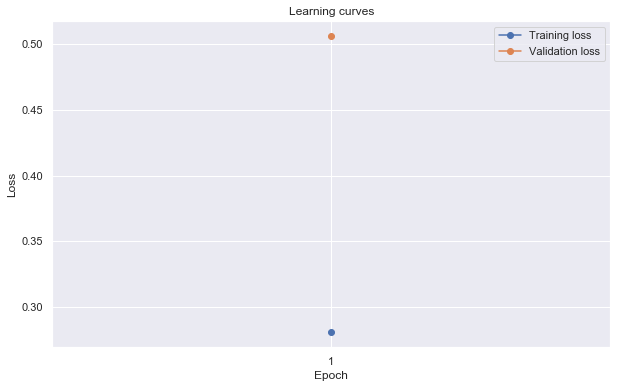

In [33]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, "-o", label="Training loss")
plt.plot(epochs, valid_losses, "-o", label="Validation loss")
plt.legend()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.show()

In [32]:
num_errors = torch.sum((y_pred != test_dataset.image_class_index).float())
print("Validation errors {} (out of {})".format(int(num_errors), len(test_dataset)))

AttributeError: 'bool' object has no attribute 'int'

In [ ]:
def predict(model, dataloader):
    # Toggle flag
    model.eval()

    pred_classes = []
    #     output_img_names = []
    with torch.no_grad():
        for i, (images, labels, indexes, predicates_mats) in enumerate(dataloader):
            images = images.to(device)
            outputs = model(images)
            sigmoid_outputs = torch.sigmoid(outputs)
            pred_labels = sigmoid_outputs  # (sigmoid_outputs > 0.5).int()
            curr_pred_classes = labels_to_class(pred_labels)
            pred_classes.extend(curr_pred_classes)
    #             output_img_names.extend(img_names)

    return pred_classes


predict(model, test_loader)